# 0. Preparación

In [1]:
%pip install pandas numpy matplotlib seaborn scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
df = pd.read_csv('data/Datos_SenecaféAlpes.csv', sep=';')

---
# 1. Análisis de calidad de datos


## 1.1 Entendimiento de los datos
**Propósito:**
Comprender qué representa cada columna antes de ver los datos reales, únicamente a partir del diccionario de datos oficial.

**Objetivo:**
Identificar el significado, la definición y el tipo de cada variable; detectar desde el inicio posibles ambigüedades, inconsistencias teóricas o información insuficiente en la documentación.

**Preguntas esenciales:**
¿Sé realmente lo que significa cada variable? ¿Hay definiciones poco claras, ambiguas o contradictorias en el diccionario?

|#| Nombre Columna | Definición | Tipo de dato esperado | ¿Qué indica o facilita? |
|----|-------|-------|-------|-------|
|1|   id    | Código único de cada grano de café      |  int/str     ||
|2|  Área     |   Superficie ocupada por grano medida en pixeles    | int      | El tamaño|
|3| Perímetro      |  Longitud de la circunferencia del grano (no especifica unidades)     | int/float      | La complejidad y continuidad del borde |
|4|   LongitudEjeMayor    |  Distancia entre los extremos mas lejanos del grano (no especifica unidades)     | int/float      | La longitud máxima del grano |
|5|   LongitudEjeMenor    | Distancia más larga de una linea trazada perpendicular al eje mayor (no especifica unidades)      |  int/float     | Ancho máximo transversal del grano |
|6|   RelaciónAspecto    | Relación entre la longitud del eje mayor y el menor    | str      | Si el resultado es >1.3 (Alargado) o si es <=1.3 (Redondeado) |
|7|  Excentricidad     | Relación de la desviación respecto a la eclipse formada por los ejes    | float      | Si el grano tiene forma circular (cercano a 0) o alargada (cercano a 1)|
|8| ÁreaConvexa      | Píxeles contenidos en el polígono convexo más pequeño que abarca el grano     | int      | Que tan irregular es el borde |
|9| DiámetroEquivalente      | Diámetro de un círculo con el mismo área que el grano (no especifica unidades)     | int/float      | Facilita la comparación entre granos de distintas formas |
|10| Medida      | Proporción entre el área del grano y su bounding box      | float      | Que tan bien un grano ocupa su espacio mínimo rectangular |
|11| Solidez      |  Proporción entre el area del grano y el área de su envolvente convexa     |  float     | La regularidad de la forma |
|12| Redondez      | Medida calculada con $\frac{4 \pi A}{P^2}$ (No especifica unidades)     | float      | Que tan circular (cercano a 1) o irregular/elongado (cercano a 0) es el grano |
|13| Compacidad      | Relación entre el diametro y el eje mayor (alternativo a la redondez)     | float      | Que tan compacto y redondeado (indices altos) es un grano |
|14| FactorForma1      | Medida geométrica derivada que combina variables básicas para caracterizar la morfología (No especifica unidades)     | float      | Ayuda a diferenciar variedades mediante combinaciones de atributos básicos |
|15| FactorForma2      | Medida complementaria de la geometría que captura diferencias sutiles en contorno y proporciones (No especifica unidades)     | float      | Permite distinguir granos con diferencias sutiles en proporciones o contorno |
|16| FactorForma3      | Indicador de forma basado en combinaciones no lineales de métricas principales (No especifica unidades)      |  float     | Aporta información adicional para la separación entre variedades. |
|17| FactorForma4      | Medida adicional que sintetiza características geométricas avanzadas (No especifica unidades) | float      | Fortalece la capacidad de clasificación en contextos complejos. |
|18|  DefectoVisible     | (Normal, Defectuoso)      | str      | Permite diferenciar entre granos sanos normales y granos con defectos visibles
|19|  MétodoSecado     | Método de procesamiento postcosecha (Natural, Lavado, Honey)      | str      | Refleja una categoría relevante en el dominio cafetero, usada en caracterización de calidad y perfiles de taza |

**Observaciones sobre el diccionario de datos:**
Se detectó que la mayoría de las variables carecen de especificación explícita de unidades. Si bien el área está declarada en píxeles, se asume que el resto de las mediciones (perímetro, ejes, diámetros) también se encuentran en píxeles, aunque sería recomendable confirmarlo con el creador del dataset. Además, varias variables derivadas dependen algebraicamente de otras básicas, lo cual debe tenerse en cuenta para futuras revisiones de consistencia y validez dentro del preprocesamiento de datos.

In [109]:
cols_medibles = ['Area', 'Perimetro', 'LongitudEjeMayor', 'LongitudEjeMenor', 'DiametroEquivalente', 'AreaConvexa']
cols_proporcionales = ['RelacionAspecto', 'Excentricidad', 'Solidez', 'Medida', 'Redondez', 'Compacidad', 'FactorForma1', 'FactorForma2', 'FactorForma3', 'FactorForma4']
cols_categoricas = ['DefectoVisible', 'MetodoSecado']
cols_id = ['ID']

## 1.2 Completitud
**Propósito:**
Evaluar si existen valores faltantes o nulos en el dataset real y qué tan severo o problemático es ese fenómeno.

**Objetivo:**
Medir el alcance y la distribución de los datos ausentes, analizar si esos vacíos se justifican, y decidir de manera argumentada cómo manejarlos (imputar, eliminar, marcar…).

**Preguntas esenciales:**
¿Qué columnas tienen nulos? ¿En qué cantidad/proporción? ¿Son justificables o indican errores? ¿Cuál es la mejor estrategia para tratarlos?


In [21]:
print('Tamaño del dataset:', df.shape)

Tamaño del dataset: (14291, 19)


In [34]:
resumen_nulos = pd.DataFrame({
    "nulos": df.isnull().sum(),
    "proporcion": df.isnull().mean()
})

resumen_nulos = resumen_nulos[resumen_nulos["nulos"] > 0]
print("Cantidad de columnas con valores nulos:", resumen_nulos.shape[0])
print(resumen_nulos.sort_values(by="proporcion", ascending=False))


Cantidad de columnas con valores nulos: 15
                     nulos  proporcion
DefectoVisible        2935    0.205374
Solidez               2306    0.161360
Redondez              2063    0.144357
DiametroEquivalente   1923    0.134560
AreaConvexa           1423    0.099573
Perimetro             1237    0.086558
FactorForma4          1159    0.081100
FactorForma1          1119    0.078301
FactorForma2          1106    0.077391
Compacidad             650    0.045483
Excentricidad          604    0.042264
MétodoSecado           587    0.041075
FactorForma3           478    0.033448
RelacionAspecto        466    0.032608
LongitudEjeMayor       401    0.028060


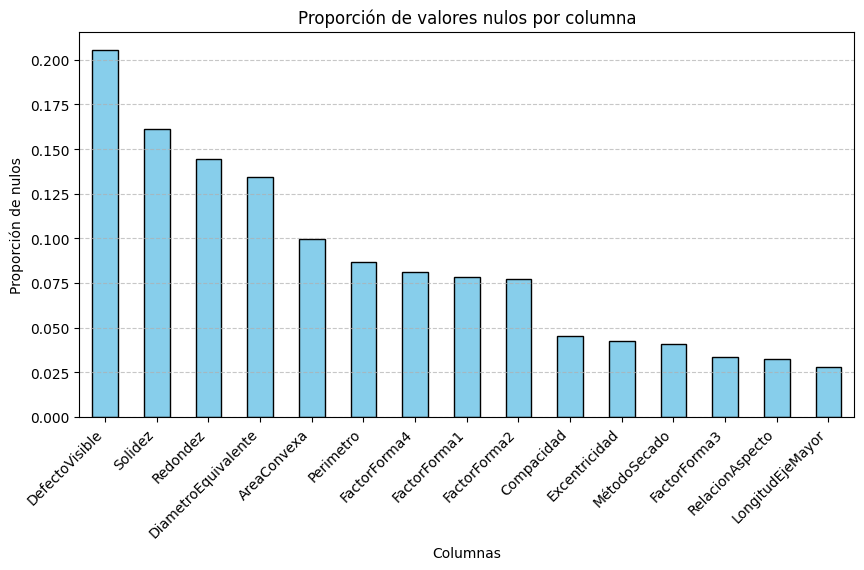

In [33]:

plt.figure(figsize=(10, 5))
resumen_nulos["proporcion"].sort_values(ascending=False).plot(
    kind="bar", color="skyblue", edgecolor="black"
)
plt.title("Proporción de valores nulos por columna")
plt.ylabel("Proporción de nulos")
plt.xlabel("Columnas")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

**DefectoVisible (categorica):** Cuenta con el 20% de los valores nulos. Un valor faltante es ambiguo, no se puede asumir si es normal o defectuoso el grano. Se podria crear una nueva categoria llamada 'Indeterminado' para evitar asunciones falsas y conservar el hecho de que el 20% de los granos no cuetan con un registro de defecto visible.

**MétodoSecado (categorica):** Cuenta con 4% de datos nulos. Es un dato que no se deriva de un análisis visual de un grano. Como todos los granos de café pasan por un método de secado, no se puede añadir una nueva categoria, por lo que valores nulos se asemejan a un error en el registro de los datos. Como se trata de una variable categorica y muy pocos nulos, estos se imputaran con la moda.

**Variables proporciones y relaciones (numéricas):** Solidez, Redondez, Compacidad, Excentricidad, RelaciónAspecto. Estas variables se pueden calcular con otras columnas, si las otras columnas presentan nulos, se podria eliminar el grano debido a falta de muchas caracteristicas nulas (en especifico si la mayoria (>40%) de las caracteristicas medibles son nulas), esto se evaluará en _____. La mayoria presentan proporciones muy bajas de nulos, por lo que imputar con la media no seria un sesgo muy grande en caso de que algunas no se puedan calcular.

**Variables medibles (numéricas):** DiametroEquivalente, AreaConvexa, Perimetro, FactorForma (1-4), LongitudEjeMayor. Estas variables no son calculables, muestran una clara falta de mediciones de ciertos granos. Para resolverlo, se podria imputar con la media dado que hay un % bajo de nulos. Hay que tener cuidado con estas variables debido a que con estos nulos resueltos se podrian calcular la mayoria de variables que representan proporciones y relaciones.


## 1.3 Unicidad
**Propósito:**
Detectar y tratar registros duplicados, que pueden derivar en análisis engañosos o resultados distorsionados.

**Objetivo:**
Establecer cuáles combinaciones de campos definen la identidad de una fila, detectar duplicidades totales o parciales, decidir cómo resolverlas y argumentar esa decisión.

**Preguntas esenciales:**
¿Hay filas idénticas o esenciales duplicadas? ¿Por qué sucedió? ¿Cómo los trato y por qué así?


In [57]:
duplicados = df[df["ID"].duplicated(keep=False)]
# display(duplicados)
print("Número de filas duplicadas basadas en 'ID':", duplicados.shape[0])
print("Porcentaje de filas duplicadas:", (duplicados.shape[0] / df.shape[0]) * 100, "%  ")


Número de filas duplicadas basadas en 'ID': 1360
Porcentaje de filas duplicadas: 9.516478902805963 %  


In [63]:
duplicadas = df[df.duplicated(keep=False)]
# display(duplicadas)
print("Número de filas duplicadas:", duplicadas.shape[0])
print("Porcentaje de filas duplicadas:", (duplicadas.shape[0] / df.shape[0])*100, '%')


Número de filas duplicadas: 922
Porcentaje de filas duplicadas: 6.451612903225806 %


**Resultados:** Hay un 9.52% de filas con el mismo ID (identificador único de cada grando de café). Hay un 6.45% de filas con todas los registros de todas las columnas dúplicados. Esto divide a los registros en 2 grupos, los duplicados exactos y los duplicados no exactos.

**Duplicados exactos:** Se eliminan porque no aportan información nueva al análisis y, por el contrario, pueden sesgar los resultados. Al eliminarlos, se garantiza que cada fila sea única y que los análisis reflejen de mejor manera la realidad de los datos.

**Duplicados no exactos:** Solo cerca del 3 % de los datos tienen este problema de tener el mismo id con información diferente. Como es un porcentaje pequeño, lo mejor es enfocarse en esos casos puntuales y revisarlos con cuidado. Lo ideal sería confirmar la información en la fuente original y decidir cuál registro conservar, o en su defecto aplicar una regla clara (por ejemplo, quedarse con el más completo o el más reciente). Así se mantiene la coherencia de los datos sin perder información valiosa.


## 1.4 Consistencia
**Propósito:**
Asegurar que las relaciones internas entre columnas y registros tienen lógica y coherencia según el dominio o reglas de negocio.

**Objetivo:**
Identificar combinaciones imposibles, secuencias temporales fallidas, sumas que no cuadran, o cualquier contradicción interna entre los datos.

**Preguntas esenciales:**
¿Hay fechas, valores o relaciones que se contradicen? ¿Dónde, cómo, y qué haré al respecto?

**Tipos de consistencia:**
- Consistencia física: Reglas que no se pueden romper
- Consistencia de cálculo: Verificar que las métricas derivadas se puedan recalcular a partir de las métricas base.
- Consistencia de rango lógico: Asegurarse de que las proporciones y relaciones estén dentro de sus rangos teóricos (ej., entre 0 y 1).



### Consistencia geométrica:
|Regla de consistencia|Columnas involucradas|Acción|
|----|----|----|
|El area convexa debe ser mayor o igual que el area del grano|Área, ÁreaConvexa|Representan errores de medición, por lo que lo mejor sea eliminarlas|
|El eje mayor debe ser mayor que el eje menor|LongitudEjeMayor, Longitud eje menor|Son errores de medición, lo mejor seria eliminar estas filas|



### Consistencias de cálculo
|Métrica a verificar|Columnas involucradas|Acción|
|----|----|----|
|RelaciónAspecto| LongitudEjeMayor, LongitudEjeMenor|Lo más posible es que las mediciones base sean las correctas, por lo que lo mejor sea corregir el valor original con el calculado|
|Solidez|Área, ÁreaConvexa|Confiar en las medidas base, corregir el valor con el calculado|
|Redondez|Área, Perímetro| Confiar en las medidas base, corregir el valor con el calculado|


### Consistencia de rango lógico
|Métrica a verificar|Justificación|Acción|
|----|----|----|
|Solidez|Como es la proporción Área/ÁreaConvexa y Área <= ÁreaConvez, el valor debe estar entre 0 y 1|Valores fuera de este rango son imposibles, por lo que se recalculará, y si persiste el error, se tratarán como NaN|
|Redondez|Un círculo perfecto tiene redondez de 1, todas las demás formas tienen valor inferior|Valores fuera de este rango son imposibles, por lo que se recalculará, y si persiste el error, se tratarán como NaN|
|Compacidad|Es la relación DiametroEquivalente / LongitudEjeMayor. No puede ser mayor que la longitud máxima.|Valores fuera de este rango son imposibles, por lo que se recalculará, y si persiste el error, se tratarán como NaN|
|RelaciónAspecto|Es la relación LongitudEjeMayor / LongitudEjeMenor. Como EjeMayor >= EjeMenor, debe ser ≥ 1|Valores fuera de este rango son imposibles, por lo que se recalculará, y si persiste el error, se tratarán como NaN|


### Evaluación de Consistencia

La etapa de consistencia se abordó según las siguientes consideraciones:

- **Consistencia geométrica:** Se definieron reglas sobre relaciones físicas entre variables (ej. área convexa ≥ área), considerándose errores de medición en caso de incumplimiento. En estos casos, se prioriza la recalculación y, si el problema persiste, se marca el registro como nulo para ser tratado posteriormente.

- **Consistencia de cálculo:** Se verificaron métricas dependientes de otras (relación aspecto, solidez, redondez y compacidad), priorizando su recalculo a partir de valores base si se detectan inconsistencias.

- **Consistencia de rango lógico:** Se establecieron intervalos aceptables para variables derivadas; valores fuera de rango se recalculan o, si la inconsistencia persiste, se marcan como nulos.

- **Prioridad en el manejo de inconsistencias:** La estrategia definida es recalcular primero, luego imputar como nulo si el error persiste, y posteriormente tratar estos casos en la etapa de completitud.

- **Registro de incidencias:** Se reconoce la importancia de medir cuántas veces se activan reglas de validación, pero se pospone este análisis hasta el manejo de valores nulos, para evitar sesgos artificiales en los conteos debidos a datos faltantes.

Este enfoque garantiza que el análisis de consistencia sea riguroso, transparente y basado en la conservación máxima de la información relevante del dataset.


## 1.5 Validez
**Propósito:**
Verificar que los datos en cada columna cumplen los formatos, rangos, tipos y restricciones definidos en el diccionario o por el negocio.

**Objetivo:**
Detectar valores inesperados, formatos incorrectos, datos fuera de rango lógico, o errores de tipeo/codificación.

**Preguntas esenciales:**
¿Hay tipos de datos mal asignados? ¿Valores imposibles (ejemplo: fecha ilógica, medida fuera de rango)? ¿Qué reglas de validación usaré para prevenirlo?

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14291 entries, 0 to 14290
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14291 non-null  object 
 1   Area                 14291 non-null  int64  
 2   Perimetro            13054 non-null  float64
 3   LongitudEjeMayor     13890 non-null  float64
 4   LongitudEjeMenor     14291 non-null  float64
 5   RelacionAspecto      13825 non-null  object 
 6   Excentricidad        13687 non-null  float64
 7   AreaConvexa          12868 non-null  float64
 8   DiametroEquivalente  12368 non-null  float64
 9   Medida               14291 non-null  float64
 10  Solidez              11985 non-null  float64
 11  Redondez             12228 non-null  float64
 12  Compacidad           13641 non-null  float64
 13  FactorForma1         13172 non-null  float64
 14  FactorForma2         13185 non-null  float64
 15  FactorForma3         13813 non-null 

### Variables marcadas como object (posibles categóricas)
Las columnas ID, RelacionAspecto, DefectoVisible y MétodoSecado se guardan como object, el resto se manejan con tipos aceptables según el entendimiento de datos. Se analizan los valores de las columnas mencionadas:

In [100]:
for col in df.select_dtypes(include=["object"]).columns:
    print(f"\nColumna: {col}")
    print(df[col].unique())



Columna: ID
['G006149' 'G007234' 'G007054' ... 'G005391' 'G000861' 'G007271']

Columna: RelacionAspecto
['alargado' 'Alargado' 'Redondeado' 'redondeado' nan]

Columna: DefectoVisible
['Normal' nan 'normal']

Columna: MétodoSecado
['Lavado' 'Natural' 'lavado' nan 'natural' 'Honey' 'honey']


- La columna ID es un identificador único de cada grano, por lo que cualquier combinación no genera problemas.
- En la columna RelacionAspecto, solo se aceptan los valores 'Alargado' y 'Redondeado', por lo que los valores que estan en minúscula se les debe transformar la primer letra a mayúscula.
- En la columna DefectoVisible, se cambian los registros 'normal' a 'Normal'. El otro caso posible ('Defectuoso') no está presente, esto puede deberse a que los registros marcados como nan representan estos datos.
- En la columna MétodoSecado tambien se corrige el error de primer letra minúscula a mayúscula.

### Variables marcadas con int y float (numéricas)

#### Varibles medibles


In [113]:
df[cols_medibles].describe().T.drop(columns=['count','mean','std','25%','50%','75%'])

,min,max
Area,-6.271600e+04,2.546160e+05
Perimetro,-1.012143e+06,1.921685e+06
LongitudEjeMayor,-4.214447e+02,7.388602e+02
LongitudEjeMenor,-2.008387e+02,4.601985e+02
DiametroEquivalente,-4.484026e+02,5.693744e+02
AreaConvexa,-7.842300e+04,2.510820e+05


La medida mínima de las columnas es negativa, esto presenta un claro error en los datos, pues las medidas físicas no pueden ser negativas. Para evitar una perdida de datos, se marcaran como nulos los valores negativos y serán corregidos por la etapa de completitud.

#### Variables proporción

In [112]:
df[cols_proporcionales].describe().T.drop(columns=['count','mean','std','25%','50%','75%'])

,min,max
Excentricidad,-0.835004,0.911423
Solidez,-0.989042,0.994378
Medida,-0.798706,0.866195
Redondez,-0.896861,0.990685
Compacidad,-0.843901,0.987303
FactorForma1,-0.007982,0.010451
FactorForma2,-0.002673,0.003665
FactorForma3,-0.683269,0.974767
FactorForma4,-0.998527,0.999733


Estas columnas presentan una proporción, por lo que es correcto que ningún máximo pase de 1. Por el otro lado, todos los mínimos están por debajo de 0. Esto presenta un claro error de cálculo, por lo que todos estos datos serán marcados como nulos para luego ser recalculados o en su defecto eliminados.

### Evaluación de Validez

En la etapa de validez se analizaron y definieron reglas para asegurar que los datos cumplen con restricciones de tipo, formato y rango según el conocimiento del dominio y el diccionario de datos.

- **Variables categóricas:** Se detectó y corrigió la falta de estandarización en mayúsculas/minúsculas, asegurando que los únicos valores válidos sean 'Alargado', 'Redondeado', 'Normal' (para DefectoVisible) y los presentes en MétodoSecado. Se dedujo que la ausencia de ciertas categorías podría explicarse por registros nulos en los datos.
- **Variables medibles:** Se identificaron valores negativos en medidas físicas, que son imposibles por definición. Estos se marcarán como nulos para ser tratados luego en la etapa de completitud.
- **Variables proporcionales:** Se comprobó que los valores máximos no exceden 1, pero existen valores mínimos negativos, lo cual es incorrecto. Esos valores serán también marcados como nulos para su corrección o tratamiento posterior.

**Prevención futura:**  
Se propuso que, para evitar errores de validez en la recolección y posterior procesamiento de datos, se implementen validaciones automáticas tanto en los formularios de captura como en los pipelines previos al análisis. Específicamente, toda variable medible y categórica debe ser validada antes de aceptar el envío, garantizando que proporciones y otras derivadas nunca caigan fuera de rango o formato.

Esta estrategia permitirá mejorar la calidad y robustez del dataset desde su origen.